# ImageDataGenerator

In [99]:
import os
from glob import glob

import tensorflow as tf
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### ImageDataGenerator 

 - 데이터를 불러오는 동시에 여러가지 전처리를 쉽게 구현 할 수 있는 tf.keras의 기능! 

In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [101]:
datagen = ImageDataGenerator(
    rotation_range = 20,        # 회전하는 각도를 랜덤하게
    width_shift_range=0.2,      # 가로로 이동하는데 20% 만큼
    height_shift_range=0.2,     # 아래 위로
    horizontal_flip=True        # 좌우 반전
)

In [102]:
# datagen.flow()

## Data Augmentation (데이터 증강기법) -> Overfitting 방지
- 딥러닝은 내가 본 데이터 한에서 잘 작동하게끔 되어있는 것이기에, general한 환경에서도 잘 작동할 수 있도록 하는것


### flow

- 데이터를 모두 메모리에 불러두고 사용 할 때

In [103]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32


In [104]:
# datagen.flow((train_x, train_y))

In [105]:
result = next(iter(datagen.flow((train_x, train_y))))

x,y = result

In [106]:
# x, y = result

In [107]:
# x.shape

In [108]:
# y.shape

In [109]:
# x[0].shape

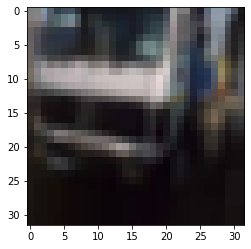

In [110]:
plt.imshow(x[0])
plt.show()

### flow_from_directory 
- 데이터를 모두 메모리에 불러오기 힘들 때

In [111]:
train_dir = "./datasets/mnist_png/training"
        # 알아서 레이블과 이미지를 받아옴

In [112]:
# os.listdir(train_dir+'/9')
            # 데이터 셋을 특정해서 정의해 놓아야 한다.

In [113]:
input_shape = (28, 28, 1)
                       # 1 채널
batch_size = 32

In [114]:
#gen = 
datagen.flow_from_directory(
    train_dir,
    target_size = input_shape[:2],        # 어떤 크기로 줄여줄지
    batch_size = batch_size,
    color_mode = 'grayscale'    # 1채널이기 때문 // rgb, rgba
)

Found 60000 images belonging to 10 classes.


In [115]:
x, y = next(iter(datagen.flow((train_x, train_y))))

In [116]:
print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 10)


### flow_from_DataFrame

In [117]:
import pandas as pd

In [118]:
# os.listdir('./datasets/cifar/')

In [119]:
train_data = pd.read_csv('./datasets/cifar/train_dataset.csv')
train_data

,path,class_name
0,../../datasets/cifar/train/32270_deer.png,deer
1,../../datasets/cifar/train/21851_cat.png,cat
2,../../datasets/cifar/train/48309_deer.png,deer
3,../../datasets/cifar/train/33547_truck.png,truck
4,../../datasets/cifar/train/45202_automobile.png,automobile
...,...,...
49995,../../datasets/cifar/train/24599_horse.png,horse
49996,../../datasets/cifar/train/38514_automobile.png,automobile
49997,../../datasets/cifar/train/20054_deer.png,deer
49998,../../datasets/cifar/train/25602_bird.png,bird


In [145]:
# fix_path = train_data['path']
fix_path = pd.DataFrame(train_data['path'])


0 path


-----------

## 문제점 발견
- path 주소가 다르다
- ../../datasets 가 아니고, ./datasets로 바뀌어야 한다...

------

In [120]:
# gen = 
datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='class_name',
    target_size = (32, 32),
    color_mode = 'rgb',
    class_model = 'categorical',
    batch_size = 32
)

Found 0 validated image filenames belonging to 0 classes.


/Users/newrandom/miniforge3/envs/TF/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 50000 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [121]:
x, y = next(iter(datagen.flow((train_x, train_y))))

In [122]:
print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 10)


학습시켜보겠습니다. 

In [123]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(64, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 8, 8, 32)    0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 8, 8, 64)     2112        ['max_pooling2d_4[0][0]']        
                                                                                             

In [124]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [125]:
model.fit(datagen.flow((train_x, train_y)))

1563/1563 [==============================] - 26s 16ms/step - loss: 2.3620 - accuracy: 0.1005
